In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from konlpy.tag import Okt
import nltk
from sklearn.linear_model import LogisticRegression
import re

In [2]:
df_fashion = pd.read_csv("../data/01. 패션.csv", encoding='utf-8', sep=",")
df_cosmetic = pd.read_csv("../data/02. 화장품.csv", encoding='utf-8', sep=",")
df_appliance = pd.read_csv("../data/03. 가전.csv", encoding='utf-8', sep=",")
df_it = pd.read_csv("../data/04. IT기기.csv", encoding='utf-8', sep=",")

# IT

In [26]:
df = df_it
df.head()

,Index,RawText,Source,Domain,MainCategory,ProductName,ReviewScore,Syllable,Word,RDate,Aspects,GeneralPolarity,label,Score_change
0,3761,제품 만족합니다. 디자인이 깔끔하고 멋스럽네요. 배송도 빠르고 좋아요.^^ 생각보다...,SNS,IT기기,컴퓨터/주변기기,펠로우즈 레더렛 메모리폼 손목받침대 (91825),100,90,18,20220304,"[{'Aspect': '디자인', 'SentimentText': '디자인이 깔끔하고...",NaN,1,5.0
1,3762,가격대비! 좋아요! 음량도 크고! 구매하세요,SNS,IT기기,컴퓨터/주변기기,[엠피지오]소나보스/사운드바 스피커/PC스피커/컴퓨터스피커/2채널/USB전원,80,24,5,20210826,"[{'Aspect': '가격', 'SentimentText': '가격대비! 좋아요!...",1.0,1,4.0
2,3763,화질도 괜찮고 타사 제품에 비해 길이가 1M정도 더 길어서 좋아요,SNS,IT기기,컴퓨터/주변기기,플레오맥스 PM-MC1000 C타입 to HDMI 미러링케이블 4K UHD 유료미디...,100,36,10,20210330,"[{'Aspect': '화질', 'SentimentText': '화질도 괜찮고 ',...",1.0,1,5.0
3,3764,"입학축하선물로 노트북 뭘 살지 이것저것 다 찾아보다가, 결국 OOOO 22형으로 주...",SNS,IT기기,컴퓨터/주변기기,[22년 신모델] LG그램 15Z95P-GA5LK (i5-1155G7/16GB/...,100,165,30,20220205,"[{'Aspect': '제조일/제조사', 'SentimentText': '역시 명불...",NaN,1,5.0
4,3765,생각보다 상당히 빨리 받았네요. OO에서 직접 배송해주는거라 설치 기사가 직접 배송...,SNS,IT기기,컴퓨터/주변기기,(1TB 외장하드 패키지)삼성직배송/설치 고성능 프리미엄 노트북 Pen NT 930...,100,214,50,20180107,"[{'Aspect': '기능', 'SentimentText': '성능 또한 상당히 ...",0.0,1,5.0


### label 은 평점 기준으로 긍정이면 1, 부정이면 0으로 라벨링 지정

#### 학습용 데이터로 가공
- 평점 8 이상 혹은 3 이하만 저장 (8 이상: 긍정적, 3 이하: 부정적)
- 각 text를 tokenize한 후, 동사, 형용사, 명사만 저장 (konlpy의 Okt 사용)

In [27]:
df['label'] = 0

In [28]:
#ReviewScore 80, 4 이상 긍정적, 50이하, 2이하 부정적으로 지정

def tokenize_korean_text(text): 
  text_filtered = re.sub('[^,.?!\w\s]','', text)

  okt = Okt() 
  Okt_morphs = okt.pos(text_filtered) 

  words = []
  for word, pos in Okt_morphs:
    if pos == 'Adjective' or pos == 'Verb' or pos == 'Noun':
      words.append(word)

  words_str = ' '.join(words)
  return words_str

## 데이터전처리 
- 점수 기준 긍/부정

In [29]:
df['Score_change'] = df['ReviewScore'].replace({100:5,90:4.5,80:4.0,70:3.5,60:3.0,50:2.5,40:2.0,30:1.5,20:1.0,10:0.5,0:0})

In [30]:
# df['label'] == 0
# 긍부정 나누는 label 생성, 점수 3 이상 긍정 3 미만 부정 / 점수 70이상 긍정 그 미만 부정 
df['label'] = df['Score_change'].apply(lambda x: 1 if x > 3.5 else 0)

In [31]:
df.head()

,Index,RawText,Source,Domain,MainCategory,ProductName,ReviewScore,Syllable,Word,RDate,Aspects,GeneralPolarity,label,Score_change
0,3761,제품 만족합니다. 디자인이 깔끔하고 멋스럽네요. 배송도 빠르고 좋아요.^^ 생각보다...,SNS,IT기기,컴퓨터/주변기기,펠로우즈 레더렛 메모리폼 손목받침대 (91825),100,90,18,20220304,"[{'Aspect': '디자인', 'SentimentText': '디자인이 깔끔하고...",NaN,1,5.0
1,3762,가격대비! 좋아요! 음량도 크고! 구매하세요,SNS,IT기기,컴퓨터/주변기기,[엠피지오]소나보스/사운드바 스피커/PC스피커/컴퓨터스피커/2채널/USB전원,80,24,5,20210826,"[{'Aspect': '가격', 'SentimentText': '가격대비! 좋아요!...",1.0,1,4.0
2,3763,화질도 괜찮고 타사 제품에 비해 길이가 1M정도 더 길어서 좋아요,SNS,IT기기,컴퓨터/주변기기,플레오맥스 PM-MC1000 C타입 to HDMI 미러링케이블 4K UHD 유료미디...,100,36,10,20210330,"[{'Aspect': '화질', 'SentimentText': '화질도 괜찮고 ',...",1.0,1,5.0
3,3764,"입학축하선물로 노트북 뭘 살지 이것저것 다 찾아보다가, 결국 OOOO 22형으로 주...",SNS,IT기기,컴퓨터/주변기기,[22년 신모델] LG그램 15Z95P-GA5LK (i5-1155G7/16GB/...,100,165,30,20220205,"[{'Aspect': '제조일/제조사', 'SentimentText': '역시 명불...",NaN,1,5.0
4,3765,생각보다 상당히 빨리 받았네요. OO에서 직접 배송해주는거라 설치 기사가 직접 배송...,SNS,IT기기,컴퓨터/주변기기,(1TB 외장하드 패키지)삼성직배송/설치 고성능 프리미엄 노트북 Pen NT 930...,100,214,50,20180107,"[{'Aspect': '기능', 'SentimentText': '성능 또한 상당히 ...",0.0,1,5.0


In [32]:
X_texts = []
y = []

aaa
for Score_change, RawText in zip(df['Score_change'], df['RawText']):
  tokenized_comment = tokenize_korean_text(RawText)  # 위에서 만들었던 함수로 comment 쪼개기
  X_texts.append(tokenized_comment)
  y.append(1 if Score_change > 3.5 else 0)

NameError: name 'aaa' is not defined

In [33]:
print(f'원래 text 수: {len(df)}')
print(f'평점 4이상 텍스트 수: {len(X_texts)}')    

원래 text 수: 41357
평점 4이상 텍스트 수: 0


In [34]:
df.head(1)

,Index,RawText,Source,Domain,MainCategory,ProductName,ReviewScore,Syllable,Word,RDate,Aspects,GeneralPolarity,label,Score_change
0,3761,제품 만족합니다. 디자인이 깔끔하고 멋스럽네요. 배송도 빠르고 좋아요.^^ 생각보다...,SNS,IT기기,컴퓨터/주변기기,펠로우즈 레더렛 메모리폼 손목받침대 (91825),100,90,18,20220304,"[{'Aspect': '디자인', 'SentimentText': '디자인이 깔끔하고...",NaN,1,5.0


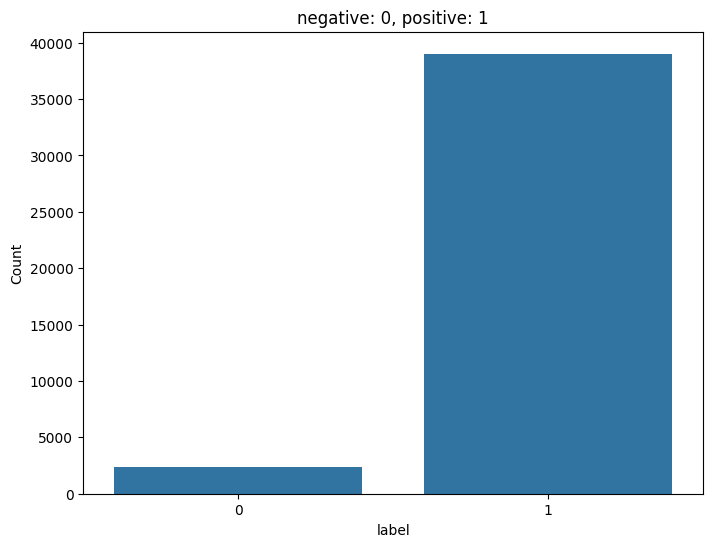

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df)
plt.title('negative: 0, positive: 1')
plt.xlabel('label')
plt.ylabel('Count')
plt.show()

In [ ]:
# train_test_split
X_train_texts, X_test_texts, y_train, y_test = train_test_split(X_texts, y, test_size=0.2, random_state=0)

In [14]:
# CountVectorizer로 vector화
tf_vectorizer = CountVectorizer(min_df=1, ngram_range=(1,1))
X_train_tf = tf_vectorizer.fit_transform(X_train_texts)  # training data에 맞게 fit & training data를 transform
X_test_tf = tf_vectorizer.transform(X_test_texts) # test data를 transform

vocablist = [word for word, number in sorted(tf_vectorizer.vocabulary_.items(), key=lambda x:x[1])]  # 단어들을 번호 기준 내림차순으로 저장

In [15]:
## 확인해보기
print(X_train_tf[:1], '\n')
print(X_test_tf[:1], '\n')
print(vocablist[:3])

  (0, 11360)	1
  (0, 21535)	1
  (0, 6419)	1
  (0, 22981)	1
  (0, 23212)	1
  (0, 8941)	1
  (0, 15590)	1
  (0, 17059)	1
  (0, 4749)	1 

  (0, 5913)	1
  (0, 5932)	1
  (0, 6928)	1
  (0, 7285)	1
  (0, 10136)	1
  (0, 11862)	1
  (0, 13637)	1
  (0, 16812)	1
  (0, 17017)	1
  (0, 17558)	1
  (0, 17746)	1 

['가가', '가게', '가격']


## 로지스틱 회귀 모델

In [36]:
logistic_model = LogisticRegression(C=0.1, penalty='l2', random_state=0)
logistic_model.fit(X_train_tf, y_train)  # 학습

LogisticRegression(C=0.1, random_state=0)

In [37]:
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

LogisticRegression(C=0.1, random_state=0)

In [38]:
y_test_pred = logistic_model.predict(X_test_tf)

print('Misclassified samples: {} out of {}'.format((y_test_pred != y_test).sum(), len(y_test)))
# print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_test_pred)))  # model.score(X_test_tf, y_test)로 계산해도 됨
print(f'Accuracy: {accuracy_score(y_test, y_test_pred)}')


Misclassified samples: 472 out of 8272
Accuracy: 0.9429400386847195


In [39]:
y_pred_series = pd.Series(y_test_pred)
value_counts = y_pred_series.value_counts()
print(value_counts)

 1    8192
-1      80
Name: count, dtype: int64


In [40]:
coefficients = logistic_model.coef_.tolist()

sorted_coefficients = sorted(enumerate(coefficients[0]), key=lambda x:x[1], reverse=True)
# coefficients(계수)가 큰 값부터 내림차순으로 정렬

print('긍정적인 단어 Top 10 (높은 평점과 상관관계가 강한 단어들)')
for word_num, coef in sorted_coefficients[:10]:
  print('{0:}({1:.3f})'.format(vocablist[word_num], coef))

print('\n부정적인 단어 Top 10 (낮은 평점과 상관관계가 강한 단어들)')
for word_num, coef in sorted_coefficients[-10:]: 
  print('{0:}({1:.3f})'.format(vocablist[word_num], coef))

긍정적인 단어 Top 10 (높은 평점과 상관관계가 강한 단어들)
최고(0.830)
좋아요(0.768)
좋습니다(0.766)
만족해요(0.743)
좋네요(0.726)
만족(0.669)
만족합니다(0.660)
만족스러워요(0.641)
감사해요(0.625)
감사합니다(0.604)

부정적인 단어 Top 10 (낮은 평점과 상관관계가 강한 단어들)
화나네요(-0.680)
안되서(-0.684)
별로(-0.695)
불만족(-0.736)
비추(-0.753)
반품(-0.762)
짜증나네요(-0.792)
안되고(-0.818)
실망(-1.053)
최악(-1.086)


In [41]:
# 긍정/부정 테스트용 함수 생성
def guess_good_or_bad(model, text):
    text_filtered = text.replace('.', '').replace(',', '').replace("'", "").replace('·', ' ').replace('=', '')
    okt = Okt()  # Corrected line
    Okt_morphs = okt.pos(text_filtered)

    words = []
    for word, pos in Okt_morphs:
        if pos == 'Adjective' or pos == 'Verb' or pos == 'Noun':
            words.append(word)
    words_str = ' '.join(words)

    # Assuming you have defined tf_vectorizer and model somewhere in your code
    new_text_tf = tf_vectorizer.transform([words_str])
    
    result = model.predict(new_text_tf)[0]

    if result == 1:
        print('긍정')
    else:
        print('부정')

In [42]:
guess_good_or_bad(logistic_model, '안되서 화나네요 최악입니다')

부정


In [43]:
guess_good_or_bad(logistic_model, '좋아요 최고')

긍정


### 모델 저장

In [44]:
import joblib

In [25]:
model_filename = 'logistic_model.joblib'
vectorizer_filename = 'vectorizer.joblib'
joblib.dump(logistic_model, model_filename)
joblib.dump(tf_vectorizer, vectorizer_filename)

['vectorizer.joblib']

# 나이브베이즈 모델

In [45]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

In [46]:
naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(X_train_tf, y_train)  # 학습
y_test_pred = naive_bayes_model.predict(X_test_tf)
print(f'Accuracy: {accuracy_score(y_test, y_test_pred)}')

Accuracy: 0.940522243713733


In [47]:
y_pred_series = pd.Series(y_test_pred)
value_counts = y_pred_series.value_counts()
print(value_counts)

 1    8052
-1     220
Name: count, dtype: int64


In [49]:
# Access feature log probabilities
feature_log_probs = naive_bayes_model.feature_log_prob_

# Calculate the difference between positive and negative log probabilities
log_prob_diff = feature_log_probs[1] - feature_log_probs[0]

# Create a list of (word, log_prob_diff) tuples
word_log_prob_diff = list(zip(vocablist, log_prob_diff))

# Sort the list by log_prob_diff in descending order
sorted_word_log_prob_diff = sorted(word_log_prob_diff, key=lambda x: x[1], reverse=True)

print('긍정적인 단어 Top 10 (높은 평점과 상관관계가 강한 단어들)')
for word, log_prob_diff in sorted_word_log_prob_diff[:10]:
    print('{0}: {1:.3f}'.format(word, log_prob_diff))

print('\n부정적인 단어 Top 10 (낮은 평점과 상관관계가 강한 단어들)')
for word, log_prob_diff in sorted_word_log_prob_diff[-10:]:
    print('{0}: {1:.3f}'.format(word, log_prob_diff))


긍정적인 단어 Top 10 (높은 평점과 상관관계가 강한 단어들)
감사해요: 3.818
감사합니다: 3.467
다니기: 2.876
안심: 2.870
편리하고: 2.822
꼼꼼하게: 2.690
매력: 2.654
이쁩니다: 2.639
효율: 2.570
기뻐요: 2.562

부정적인 단어 Top 10 (낮은 평점과 상관관계가 강한 단어들)
받지도: -3.652
보내라: -3.652
빵점: -3.652
억지로: -3.652
인쇄물: -3.652
참조: -3.652
못잡고: -3.876
성질: -3.876
저장장치: -3.876
콜센터: -3.876


In [52]:
guess_good_or_bad(naive_bayes_model, '좋아요 최고')

긍정


In [ ]:
guess_good_or_bad(naive_bayes_model, '좋아요 최고')

In [53]:
model_filename = 'naive_bayes_model.joblib'
vectorizer_filename = 'vectorizer.joblib'
joblib.dump(naive_bayes_model, model_filename)
joblib.dump(tf_vectorizer, vectorizer_filename)

['vectorizer.joblib']

# BERT model

In [36]:
import numpy as np
import pandas as pd
import tensorflow as tf
from transformers import TFBertModel, BertTokenizer
import warnings
warnings.filterwarnings('ignore')

#### 토크나이저를 불러온다 

In [37]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [38]:
df.head(1)

,Index,RawText,Source,Domain,MainCategory,ProductName,ReviewScore,Syllable,Word,RDate,Aspects,GeneralPolarity,label,Score_change
0,3761,제품 만족합니다. 디자인이 깔끔하고 멋스럽네요. 배송도 빠르고 좋아요.^^ 생각보다...,SNS,IT기기,컴퓨터/주변기기,펠로우즈 레더렛 메모리폼 손목받침대 (91825),100,90,18,20220304,"[{'Aspect': '디자인', 'SentimentText': '디자인이 깔끔하고...",NaN,1,5.0


In [39]:
# train_test_split
X_train_texts, X_test_texts, y_train, y_test = train_test_split(df['RawText'], df['label'], test_size=0.2, random_state=0)

# 레이블을 정수형으로 변환
y_train = [int(label) for label in y_train]
y_test = [int(label) for label in y_test]

# 레이블을 넘파이 배열로 변환
y_train = np.array(y_train)
y_test = np.array(y_test)

X_train_texts.shape, X_test_texts.shape, y_train.shape, y_test.shape

((33085,), (8272,), (33085,), (8272,))

In [40]:
np.unique(y_train)

array([0, 1])

#### 토큰화

In [41]:
def encode(data, tokenizer):
    input_ids = []
    attention_masks = []
    token_type_ids = []
 
    for text in data:
        tokenized_text = tokenizer.encode_plus(text,
                                            max_length=50,
                                            add_special_tokens = True,
                                            pad_to_max_length=True,
                                            return_attention_mask=True,
                                              truncation=True)
        
        input_ids.append(tokenized_text['input_ids'])
        attention_masks.append(tokenized_text['attention_mask'])
        token_type_ids.append(tokenized_text['token_type_ids'])
    
    return input_ids, attention_masks, token_type_ids

-  동일하게  encode 함수를 정의해서 토큰화를 실시한다. 여기서는 token_type_ids 정보도 추출하는데, 이는 각 토큰의 문장 임베딩 정보를 포함하고 있다. 여기서는 리뷰가 한개씩 입력되지만, 원래 BERT모델은 두 개의 문장을 입력받기 때문에 동일한 구조로 사용하기 위해서 해당 정보도 추출한다. 

In [42]:
#학습데이터 토큰화
train_input_ids, train_attention_masks, train_token_type_ids = encode(X_train_texts, tokenizer)
 
#테스트데이터 토큰화
test_input_ids, test_attention_masks, test_token_type_ids = encode(X_test_texts, tokenizer)

In [43]:
len(train_input_ids)

33085

### BERT 모델 입력을 위한 형태로 처리 

In [44]:
#딕셔너리 형태로 변환해서 출력 
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
    return {
      "input_ids": input_ids,
      "token_type_ids": token_type_ids,
      "attention_mask": attention_masks,
      }, label
      
 #데이터를 BERT에 넣을 수 있는 형태로 변경 
def data_encode(input_ids_list, attention_mask_list, token_type_ids_list, label_list):
    return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)

In [45]:
BATCH_SIZE = 32
 
# 학습 데이터셋 생성
train_data_encoded = data_encode(train_input_ids, train_attention_masks, train_token_type_ids, y_train).shuffle(10000).batch(BATCH_SIZE)
 
# 테스트 데이터셋 생성
test_data_encoded = data_encode(test_input_ids, test_attention_masks, test_token_type_ids, y_test).batch(BATCH_SIZE)

### 모델 학습 

In [46]:
model = TFBertModel.from_pretrained('bert-base-uncased', output_hidden_states = True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [47]:
from transformers import TFBertForSequenceClassification
# 모델 정의
BERT_model = TFBertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [48]:
# 옵티마이저, 손실 함수, 평가 메트릭 설정
optimizer = tf.keras.optimizers.Adam(1e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
BERT_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# 모델 훈련
NUM_EPOCHS = 10
history = BERT_model.fit(train_data_encoded, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_data=test_data_encoded)

Epoch 1/10
  60/1034 [>.............................] - ETA: 3:10:12 - loss: 0.2582 - accuracy: 0.9245

KeyboardInterrupt: 

### 결과 확인

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

### 정확도

In [ ]:
#정확도 확인 
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','val'])
plt.show()

In [ ]:
# 출처
# https://yeong-jin-data-blog.tistory.com/entry/BERT%EB%A1%9C-%EC%98%81%ED%99%94-%EB%A6%AC%EB%B7%B0-%EA%B0%90%EC%84%B1-%EB%B6%84%EC%84%9D%ED%95%98%EA%B8%B0

# BERT model (중지)

In [59]:
# Bert 사용에 필요한 모듈 불러오기
import torch

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, Adafactor, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import random
import time
import datetime

BERT는 문장의 앞에 [CLS]를 붙이고, 끝에는 [SEP]을 붙여 처리를 해 주어야한다. 그러므로 반복문 등을 활용하여 처리해 주어야한다.

In [64]:
X_train_texts[:5]

['색감 표현 떨어져 화질 흐릿 배터리 용량 작아 쓸 때 답답',
 '미리 문해 잘 받았습니다 디자인 기대했던것 만큼 세련되서 좋아요 배터리 단다고 해서 걱정 했는데 진짜 사용 시간 짧네요 핑골 색상 선택 하길 했어요 고급스러워요',
 '주변 제품 평이 넘 좋아서 샀는데 다른 제품 비해 확실히 편해서 맘 들어요 모르고 샀는데 받고 보니 키 보드 마우스 셋트 구성 상품 이었네요 구성 최고',
 '사은 품 받은 케이스 귀여워요 주문 하는 바람 쪼금 더 비싼 가격 산 게 아쉽네요 또 달리다가 멈출 때 삐 소리 나 게 거슬려서 좀 별로 예전 쓰던 제품 좋아요',
 '화면 선명하게 잘 보입니다 녹화 것 훨 보기 좋아 만족해요 안전 운전 멘트 나오는것도 마음 들어요']

In [65]:
# BERT에 맞는 Tag 달아주기
bert_text = []

for i in X_train_texts:
  bert = ["[CLS] " + str(i) + " [SEP]"]
  bert_text.append(bert)

bert_text[:5]

[['[CLS] 색감 표현 떨어져 화질 흐릿 배터리 용량 작아 쓸 때 답답 [SEP]'],
 ['[CLS] 미리 문해 잘 받았습니다 디자인 기대했던것 만큼 세련되서 좋아요 배터리 단다고 해서 걱정 했는데 진짜 사용 시간 짧네요 핑골 색상 선택 하길 했어요 고급스러워요 [SEP]'],
 ['[CLS] 주변 제품 평이 넘 좋아서 샀는데 다른 제품 비해 확실히 편해서 맘 들어요 모르고 샀는데 받고 보니 키 보드 마우스 셋트 구성 상품 이었네요 구성 최고 [SEP]'],
 ['[CLS] 사은 품 받은 케이스 귀여워요 주문 하는 바람 쪼금 더 비싼 가격 산 게 아쉽네요 또 달리다가 멈출 때 삐 소리 나 게 거슬려서 좀 별로 예전 쓰던 제품 좋아요 [SEP]'],
 ['[CLS] 화면 선명하게 잘 보입니다 녹화 것 훨 보기 좋아 만족해요 안전 운전 멘트 나오는것도 마음 들어요 [SEP]']]

- 이전 단계에서 이미 토큰화된 것을 사용하면 좋겠지만, 위와 같이 CLS 및 SEP 태그를 달아주어야 했기 때문에, 최초의 데이터를 활용했다. 이번에는 Bert multilingual 모델에 있는 tokenizer를 활용하여 토큰화한다.

### 토큰화

In [66]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_data = []
for i in bert_text:
  for j in i:
    tokens = tokenizer.tokenize(j)
    tokenized_data.append(tokens)

print(tokenized_data[0:10])

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

C:\Users\wisei\miniconda3\Lib\site-packages\huggingface_hub\file_download.py:148: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\wisei\.cache\huggingface\hub\models--bert-base-multilingual-cased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

[['[CLS]', '색', '##감', '표', '##현', '떨', '##어져', '화', '##질', '흐', '##릿', '배', '##터', '##리', '용', '##량', '작', '##아', '쓸', '때', '답', '##답', '[SEP]'], ['[CLS]', '미', '##리', '문', '##해', '잘', '받', '##았', '##습', '##니다', '디', '##자인', '기', '##대', '##했던', '##것', '만', '##큼', '세', '##련', '##되', '##서', '좋', '##아', '##요', '배', '##터', '##리', '단', '##다고', '해', '##서', '걱', '##정', '했', '##는데', '진', '##짜', '사', '##용', '시', '##간', '짧', '##네', '##요', '핑', '##골', '색', '##상', '선', '##택', '하', '##길', '했', '##어', '##요', '고', '##급', '##스', '##러', '##워', '##요', '[SEP]'], ['[CLS]', '주', '##변', '제', '##품', '평', '##이', '넘', '좋', '##아', '##서', '샀', '##는데', '다른', '제', '##품', '비해', '확', '##실', '##히', '편', '##해서', '맘', '들어', '##요', '모', '##르고', '샀', '##는데', '받고', '보', '##니', '키', '보', '##드', '마', '##우스', '셋', '##트', '구', '##성', '상', '##품', '이', '##었', '##네', '##요', '구', '##성', '최고', '[SEP]'], ['[CLS]', '사', '##은', '품', '받은', '케', '##이스', '귀', '##여', '##워', '##요', '주', '##문', '하는', '바', '##람', '[UNK]', '더', '비', '##싼', 

- 이전 딥러닝 수업에서 padding이 매우 중요하다고 배웠다. 가장자리에 있는 데이터들이 1번만 사용되는 것을 막기 위해 기존 데이터에 0의 테두리를 두르는 것이다. 이 작업이 BERT 모델을 돌리기 위해서도 필요하다.

In [70]:
tokenized_test_data = []
for i in X_test_texts:
  for j in i:
    tokens = tokenizer.tokenize(j)
    tokenized_test_data.append(tokens)

print(tokenized_test_data[0:5])

[['저'], ['음'], [], ['작'], ['게']]


In [71]:
# padding
input_ids = []
for i in tokenized_data:
  ids = tokenizer.convert_tokens_to_ids(i)
  input_ids.append(ids)

print(input_ids[0])

[101, 9416, 105197, 9934, 30842, 9141, 65164, 9993, 48599, 10015, 118906, 9330, 21876, 12692, 9603, 44321, 9652, 16985, 9513, 9137, 9065, 118775, 102]


In [74]:
input_ids_test = []
for i in tokenized_test_data:
  ids = tokenizer.convert_tokens_to_ids(i)
  input_ids_test.append(ids)

print(input_ids_test[1])

[9634]


In [75]:
max_len = 128
input_ids = pad_sequences(input_ids, maxlen=max_len, dtype='long', truncating='post', padding='post')
input_ids[0]

array([   101,   9416, 105197,   9934,  30842,   9141,  65164,   9993,
        48599,  10015, 118906,   9330,  21876,  12692,   9603,  44321,
         9652,  16985,   9513,   9137,   9065, 118775,    102,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
      

In [76]:
input_ids_test = pad_sequences(input_ids_test, maxlen=max_len, dtype='long', truncating='post', padding='post')
input_ids_test[0]

array([9663,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0])

In [77]:
attention_masks = []

for ids in input_ids:
  ids_mask = []
  for id in ids:
      masked = float(id>0)
      ids_mask.append(masked)
  attention_masks.append(ids_mask)
    
print(attention_masks[0])
print(len(attention_masks[0]))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
128


In [78]:
attention_masks_test = []

for ids in input_ids_test:
  ids_mask = []
  for id in ids:
      masked = float(id>0)
      ids_mask.append(masked)
  attention_masks_test.append(ids_mask)
    
print(attention_masks_test[0])
print(len(attention_masks_test[0]))

[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
128


In [ ]:
X_texts_cos = []
y_cos = []

for Score_change, RawText in zip(df2['Score_change'], df2['RawText']):
  tokenized_comment = tokenize_korean_text_2(RawText)  # 위에서 만들었던 함수로 comment 쪼개기
  X_texts_cos.append(tokenized_comment)
  y_cos.append(1 if Score_change > 3.5 else 0)

- 모델링을 위해서는 train 데이터와 validation 데이터를 분리해야한다. 테스트 데이터는 이미 분리되어있다. 다만 이후 모델의 fine-tuning을 위한 데이터와, 이후 모델링을 위해 tensor로 변환할 데이터를 분리해 주어야한다.

In [81]:
X_train, X_val, y_train, y_val = train_test_split(
    input_ids, y_train, random_state=42, test_size=0.2)

train_masks, validation_masks, _, _ = train_test_split(attention_masks, 
                                                       input_ids,
                                                       random_state=42, 
                                                       test_size=0.2)

In [84]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

AttributeError: 'list' object has no attribute 'shape'

In [85]:
X_train.shape, X_val.shape

((26468, 128), (6617, 128))

In [88]:
a = np.array(y_train)
a.shape

(26468,)

In [ ]:
y_train.shape, y_val.shape

In [ ]:
# Fine-tuning과 Tensor로 사용할 데이터를 분리
X_train_tune = X_train
y_train_tune = y_train
X_val_tune = X_val
y_val_tune = y_val

In [ ]:
X_test_tensor = input_ids_test
y_test_tensor = test_data["label"].values
test_masks = attention_masks_test

- 다음으로 input_ids, 타깃 라벨, masking을 PyTorch로 변환해야한다.

In [ ]:
cos_data_tf = tf_vectorizer.transform(X_texts_cos)

In [ ]:
cos_data_predictions = model.predict(cos_data_tf)

In [ ]:
for text, prediction in zip(X_texts_cos, cos_data_predictions):
    sentiment = "Positive" if prediction == 1 else "Negative"
    print(f'Text: "{text}", Predicted Sentiment: {sentiment}')

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
cos_data_accuracy = accuracy_score(y_cos, cos_data_predictions)
print(f'Accuracy on new data: {cos_data_accuracy}')

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df2)
plt.title('negative: 0, positive: 1')
plt.xlabel('label')
plt.ylabel('Count')
plt.show()

In [ ]:
# PyTorch로 변환

X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train)
train_masks = torch.tensor(train_masks)
X_val_tensor = torch.tensor(X_val)
y_val_tensor = torch.tensor(y_val)
validation_masks = torch.tensor(validation_masks)

In [ ]:
X_test_tensor = torch.tensor(X_test_tensor)
y_test_tensor = torch.tensor(y_test_tensor)
test_masks = torch.tensor(attention_masks_test)

- 이번에는 배치 사이즈를 지정한다. 주로 큰 사이즈를 설정해보고, VRAM 에러 메시지가 난다면, 더 작은 사이즈로 줄여나간다. 8의 배수로 설정하는 것이 일반적이다. 한 블로그를 참조[2]해보니, 32일 때 가장 좋은 성능이 나왔다고 한다. 그래서 이를 batch_size의 값으로 설정했다.

In [ ]:
batch_size = 32

train = TensorDataset(X_train_tensor, train_masks, y_train_tensor)
train_sampler = RandomSampler(train)

val = TensorDataset(X_val_tensor, validation_masks, y_val_tensor)
val_sampler = SequentialSampler(val)


test = TensorDataset(X_test_tensor, test_masks, y_test_tensor)
test_sampler = RandomSampler(test)

train_dataloader = DataLoader(train, sampler=train_sampler, batch_size=batch_size)
val_dataloader = DataLoader(val, sampler=val_sampler, batch_size=batch_size)
test_dataloader = DataLoader(test, sampler=test_sampler, batch_size=batch_size)